<a href="https://colab.research.google.com/github/amir9ume/practice_work/blob/master/Hate_speech_detection_task_BERT_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
##
Original code taken from https://mccormickml.com/2019/07/22/BERT-fine-tuning/
Authors Chris McCormick and Nick Ryan
Wonderful ,easy to follow tutorial. 
##
"""

import tensorflow as tf
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if 'cuda' in str(device): 

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')  
    print('No GPU available, using the CPU instead.')
    


There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [0]:
!pip install transformers

In [0]:
!pip install wget

In [0]:
import wget
import os

print('Downloading dataset...')

import pandas as pd
url= 'https://github.com/t-davidson/hate-speech-and-offensive-language/raw/master/data/labeled_data.csv'
df= pd.read_csv(url)
print('Size of training data ', df.shape[0])
df.sample(10)



Size of training data  24783


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
19036,19460,3,1,2,0,1,RT @gamma_ray239: The wicked witch of the east...
15627,15993,3,0,3,0,1,RT @ImNeverChillin: You bitches are so inconsi...
18949,19368,3,0,3,0,1,"RT @eddiekinggg: I completely lost my mind, if..."
3058,3135,3,0,3,0,1,@DoubleAIV just watch bitch nigga u gonna want...
6075,6250,3,0,3,0,1,@heartlle @Kaleigh_McNasty bitch look like she...
17061,17451,3,0,3,0,1,"RT @RealNiggaSherm: ""@1stBlocJeremiah: @RealNi..."
8329,8559,3,0,3,0,1,Can you catch a box hoe ?
23578,24071,3,0,2,1,1,and trying to maintain this color is gonna be ...
20038,20481,3,1,2,0,1,RT @socass_: &#8220;@00sexilexi00: @socass_ I ...
12924,13243,3,0,3,0,1,"Mum agrees with me, ur being a wee moody cunt ..."


In [0]:
import re
# Get the lists of sentences and their labels.
sentences = df.tweet.values
labels = df['class'].values

print(sentences[:3],'\n')
sentences = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in sentences]

print(sentences[:3])
print(labels[:3])

["!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."
 '!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!'
 '!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit'] 

[' RT mayasolovely As a woman you shouldn t complain about cleaning up your house amp as a man you should always take the trash out ', ' RT mleew17 boy dats cold tyga dwn bad for cuffin dat hoe in the 1st place ', ' RT UrKindOfBrand Dawg RT 80sbaby4life You ever fuck a bitch and she start to cry You be confused as shit']
[2 1 1]


In [0]:
! 
from transformers import BertTokenizer

# Load the BERT tokenizer.
#Adding lower case =True is required if you are running the uncased model
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
# Print the original sentence.
print(' Original: ', sentences[2])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[2]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[2])))

#Bert encode does tokenization and convert to ids, at the same time
print('Token IDS: ', tokenizer.encode(sentences[2] , add_special_tokens=True))

print(tokenizer.encode('@UrKindofBrand',add_special_tokens=True))

 Original:   RT UrKindOfBrand Dawg RT 80sbaby4life You ever fuck a bitch and she start to cry You be confused as shit
Tokenized:  ['rt', 'ur', '##kind', '##of', '##brand', 'da', '##wg', 'rt', '80s', '##ba', '##by', '##4', '##life', 'you', 'ever', 'fuck', 'a', 'bitch', 'and', 'she', 'start', 'to', 'cry', 'you', 'be', 'confused', 'as', 'shit']
Token IDs:  [19387, 24471, 18824, 11253, 23544, 4830, 27767, 19387, 16002, 3676, 3762, 2549, 15509, 2017, 2412, 6616, 1037, 7743, 1998, 2016, 2707, 2000, 5390, 2017, 2022, 5457, 2004, 4485]
Token IDS:  [101, 19387, 24471, 18824, 11253, 23544, 4830, 27767, 19387, 16002, 3676, 3762, 2549, 15509, 2017, 2412, 6616, 1037, 7743, 1998, 2016, 2707, 2000, 5390, 2017, 2022, 5457, 2004, 4485, 102]
[101, 1030, 24471, 18824, 11253, 23544, 102]


### Special Tokens



**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

I am not certain yet why the token is still required when we have only single-sentence input, but it is!


**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. Because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!



The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







## Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [0]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
for sent in sentences:
  token_ids= tokenizer.encode(sent, add_special_tokens=True)
  if len(token_ids)==max_len:
    print('Longest sentence is : ')
    print(sent)



Max sentence length:  247
Longest sentence is : 
RT TrxllLegend One good girl is worth a thousand bitches 128112 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 128109 8230 


In [0]:
# Tokenize all of the sentences and map the tokens to their word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`. Use a buffer on maxLength value
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len+10,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])


# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
#input_ids= torch.squeeze(torch.FloatTensor(input_ids) ,dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])


Original:   RT mayasolovely As a woman you shouldn t complain about cleaning up your house amp as a man you should always take the trash out 
Token IDs: tensor([  101, 19387,  9815, 19454, 21818,  2135,  2004,  1037,  2450,  2017,
         5807,  1056, 17612,  2055,  9344,  2039,  2115,  2160, 23713,  2004,
         1037,  2158,  2017,  2323,  2467,  2202,  1996, 11669,  2041,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,    

In [0]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
#The TensorDataset takes an arbitrary number of input tensors.
dataset = TensorDataset(input_ids, attention_masks, labels)


# Create a 70-15-15 train-validation-test split.

# Calculate the number of samples to include in each set.
train_size = int(0.7 * len(dataset))
val_size= int(0.15* len(dataset))
test_size = len(dataset) - train_size - val_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_set = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

17,348 training samples
3,717 validation samples
3,718 test samples


We'll also create an iterator for our dataset using the torch DataLoader class. **This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.**

In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader= DataLoader(
            test_set,
            sampler= SequentialSampler(test_set),
            batch_size= batch_size
)

##BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  





We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)


model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

##  Training Loop

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
#Define a helper function for calculating accuracy.
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
# Helper function for formatting elapsed times as `hh:mm:ss`

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
#You can use torch.manual_seed() 80 to seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *model*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
      
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass. 
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
       
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches. At the end of one epoch, across all minibatches
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:  
      
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU. Why??
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.Across all mini batches
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    543.    Elapsed: 0:00:32.
  Batch    80  of    543.    Elapsed: 0:01:04.
  Batch   120  of    543.    Elapsed: 0:01:36.
  Batch   160  of    543.    Elapsed: 0:02:07.
  Batch   200  of    543.    Elapsed: 0:02:39.
  Batch   240  of    543.    Elapsed: 0:03:11.
  Batch   280  of    543.    Elapsed: 0:03:43.
  Batch   320  of    543.    Elapsed: 0:04:15.
  Batch   360  of    543.    Elapsed: 0:04:47.
  Batch   400  of    543.    Elapsed: 0:05:19.
  Batch   440  of    543.    Elapsed: 0:05:51.
  Batch   480  of    543.    Elapsed: 0:06:22.
  Batch   520  of    543.    Elapsed: 0:06:54.

  Average training loss: 0.32
  Training epcoh took: 0:07:12

Running Validation...
  Accuracy: 0.91
  Validation Loss: 0.24
  Validation took: 0:00:30

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    543.    Elapsed: 0:00:32.
  Batch    80  of    543.    Elapsed: 0:01:04.
  Batch   120  of    543.    Elapsed: 0:01:36.
  Batch  

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.32,0.24,0.91,0:07:12,0:00:30
2,0.22,0.24,0.92,0:07:13,0:00:30


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


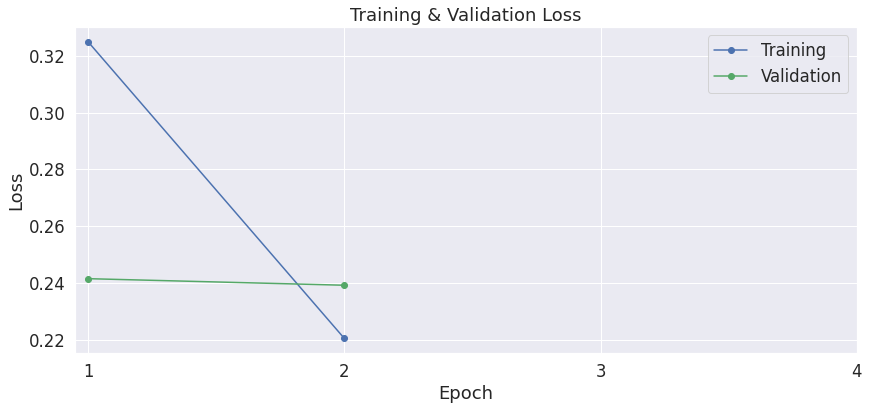

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (14,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Evaluate on Test data



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [0]:
#Enter a sentence, and model will infer if 0-hate speech, 1- offensive or 2-neutral speech
x= 'i dont like you at all'

dict1 = tokenizer.encode_plus(
                    x,                      # Sentence to encode.
                    add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                    max_length = max_len+10,           # Pad & truncate all sentences.
                    pad_to_max_length = True,
                    return_attention_mask = True,   # Construct attn. masks.
                    return_tensors = 'pt',     # Return pytorch tensors.
                )


test_tokens=(dict1['input_ids']).to(device)
attention_masks=(dict1['attention_mask']).to(device)


with torch.no_grad():
  outputs= model(test_tokens, attention_masks, token_type_ids=None) 

prediction= outputs[0].detach().cpu().numpy()
label_ids = labels.to('cpu').numpy()

out=np.argmax(prediction,axis=1)

print('The sentence: ',x,' is : ')
if out ==0:
  print('Hate speech')
elif out== 1:
  print('Offensive')
else:
  print('Neutral')  



The sentence:  i dont like you at all  is : 
Neutral


In [0]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/my_practice_dl/BERT Fine-Tuning/"

cp: cannot stat './model_save/': No such file or directory


In [0]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)